# Predicting Used Cars Prices

This data is scraped every few months, it contains most all relevant information that **Craigslist** provides on car sales including columns like price, condition, manufacturer, latitude/longitude, and 18 other categories. 

For this notebook I will only import relevant informations, since entries id or urls and car's vehicle identification number etc. won't be needed for this notebook. 

The Dataset can be found [here](https://www.kaggle.com/austinreese/craigslist-carstrucks-data)

## Loading Packages and Dataset

In [158]:
import pandas as pd
import numpy as np
from numpy import mean

import geopandas
import plotly.io as pio
from IPython.display import SVG, display, Image
import kaleido
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import metrics
import math

In [2]:
# Importing only relevant columns, since Informations such as entries url or id are not relevant for this analysis. 

col_list = ['region', 'state', 'price', 'year', 'manufacturer', 'model', 'condition',
            'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', "lat", "long",
            'drive', 'type']

schema = {'region':"category", 'state':"category",'price':"int64", 'year':"float32",  'manufacturer':"category", 'model':"str", 
          'condition':"category",'cylinders':"category", 'fuel':"category", 'odometer':"float32", 'title_status':"category", 
          'transmission':"category", 'drive':"category", 'type':"category"}

df_initial = pd.read_csv("./vehicles.csv", usecols=col_list, dtype=schema)

In [3]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   region        426880 non-null  category
 1   price         426880 non-null  int64   
 2   year          425675 non-null  float32 
 3   manufacturer  409234 non-null  category
 4   model         421603 non-null  object  
 5   condition     252776 non-null  category
 6   cylinders     249202 non-null  category
 7   fuel          423867 non-null  category
 8   odometer      422480 non-null  float32 
 9   title_status  418638 non-null  category
 10  transmission  424324 non-null  category
 11  drive         296313 non-null  category
 12  type          334022 non-null  category
 13  state         426880 non-null  category
 14  lat           420331 non-null  float64 
 15  long          420331 non-null  float64 
dtypes: category(10), float32(2), float64(2), int64(1), object(1)
memory usage:

In [4]:
df_initial.sample()

region  price    year manufacturer      model  condition  \
205539  lansing   9640  2016.0      hyundai  accent se  excellent   

          cylinders fuel  odometer title_status transmission drive   type  \
205539  4 cylinders  gas   71072.0          NaN    automatic   NaN  sedan   

       state        lat       long  
205539    mi  42.300673 -84.024108

In [5]:
df_initial.shape

(426880, 16)

## Preprocessing and cleaning the Data

In [6]:
def missing_values(df):
    return (df.isnull().sum()*100 /len(df)).sort_values(ascending=False)
    

In [42]:
df1 = df_initial.copy(deep=True)

In [43]:
df1.head(10)

region  price  year manufacturer model condition cylinders  \
0                prescott   6000   NaN          NaN   NaN       NaN       NaN   
1            fayetteville  11900   NaN          NaN   NaN       NaN       NaN   
2            florida keys  21000   NaN          NaN   NaN       NaN       NaN   
3  worcester / central MA   1500   NaN          NaN   NaN       NaN       NaN   
4              greensboro   4900   NaN          NaN   NaN       NaN       NaN   
5           hudson valley   1600   NaN          NaN   NaN       NaN       NaN   
6           hudson valley   1000   NaN          NaN   NaN       NaN       NaN   
7           hudson valley  15995   NaN          NaN   NaN       NaN       NaN   
8         medford-ashland   5000   NaN          NaN   NaN       NaN       NaN   
9                    erie   3000   NaN          NaN   NaN       NaN       NaN   

  fuel  odometer title_status transmission drive type state  lat  long  
0  NaN       NaN          NaN          NaN   NaN  NaN    az  NaN   NaN  
1  NaN       NaN          NaN          NaN   NaN  NaN    ar  NaN   NaN  
2  NaN       NaN          NaN          NaN   NaN  NaN    fl  NaN   NaN  
3  NaN       NaN          NaN          NaN   NaN  NaN    ma  NaN   NaN  
4  NaN       NaN          NaN          NaN   NaN  NaN    nc  NaN   NaN  
5  NaN       NaN          NaN          NaN   NaN  NaN    ny  NaN   NaN  
6  NaN       NaN          NaN          NaN   NaN  NaN    ny  NaN   NaN  
7  NaN       NaN          NaN          NaN   NaN  NaN    ny  NaN   NaN  
8  NaN       NaN          NaN          NaN   NaN  NaN    or  NaN   NaN  
9  NaN       NaN          NaN          NaN   NaN  NaN    pa  NaN   NaN

In [44]:
missing_values(df1)

cylinders       41.622470
condition       40.785232
drive           30.586347
type            21.752717
manufacturer     4.133714
title_status     1.930753
lat              1.534155
long             1.534155
model            1.236179
odometer         1.030735
fuel             0.705819
transmission     0.598763
year             0.282281
region           0.000000
price            0.000000
state            0.000000
dtype: float64

In [45]:
df1.shape

(426880, 16)

In [46]:
df1.describe([0.01, 0.25, 0.5, 0.75, 0.99])

price           year      odometer            lat           long
count  4.268800e+05  425675.000000  4.224800e+05  420331.000000  420331.000000
mean   7.519903e+04    2009.413696  9.804179e+04      38.493940     -94.748599
std    1.218228e+07       9.626303  2.138404e+05       5.841533      18.365462
min    0.000000e+00    1900.000000  0.000000e+00     -84.122245    -159.827728
1%     0.000000e+00    1967.000000  2.000000e+00      25.844662    -149.869094
25%    5.900000e+03    2008.000000  3.770400e+04      34.601900    -111.939847
50%    1.395000e+04    2013.000000  8.554800e+04      39.150100     -88.432600
75%    2.648575e+04    2017.000000  1.335425e+05      42.398900     -80.832039
99%    6.699500e+04    2020.000000  2.800000e+05      48.754959     -71.081834
max    3.736929e+09    2022.000000  1.000000e+07      82.390818     173.885502

### First look

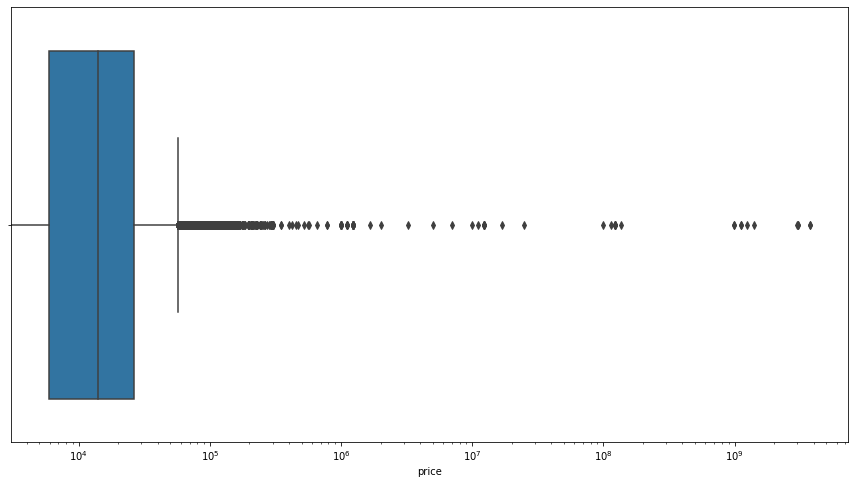

In [47]:
plt.figure(figsize = (15,8))
ax = sns.boxplot(x=df1["price"], orient="h")
ax.set_xscale('log')

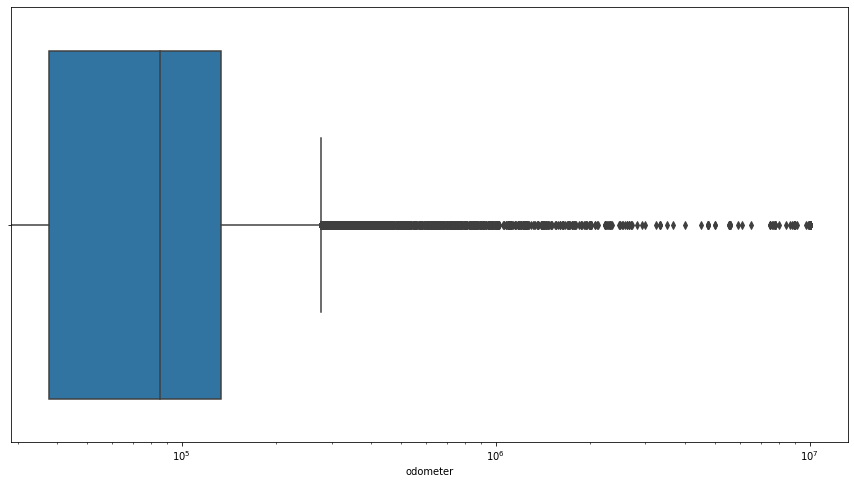

In [48]:
plt.figure(figsize = (15,8))
ax = sns.boxplot(x=df1["odometer"], orient="h")
ax.set_xscale('log')

In [49]:
df1[df1["price"] == 0]

region  price    year manufacturer          model  condition  \
10      el paso      0     NaN          NaN            NaN        NaN   
11      el paso      0     NaN          NaN            NaN        NaN   
12      el paso      0     NaN          NaN            NaN        NaN   
13      el paso      0     NaN          NaN            NaN        NaN   
14      el paso      0     NaN          NaN            NaN        NaN   
...         ...    ...     ...          ...            ...        ...   
426764  wyoming      0  2018.0          NaN  peterbilt 579        NaN   
426812  wyoming      0  2006.0       toyota       scion tc  excellent   
426832  wyoming      0  2004.0       toyota          prius  excellent   
426836  wyoming      0  2018.0          ram           2500  excellent   
426868  wyoming      0  2010.0       toyota          venza  excellent   

          cylinders    fuel  odometer title_status transmission drive   type  \
10              NaN     NaN       NaN          NaN          NaN   NaN    NaN   
11              NaN     NaN       NaN          NaN          NaN   NaN    NaN   
12              NaN     NaN       NaN          NaN          NaN   NaN    NaN   
13              NaN     NaN       NaN          NaN          NaN   NaN    NaN   
14              NaN     NaN       NaN          NaN          NaN   NaN    NaN   
...             ...     ...       ...          ...          ...   ...    ...   
426764          NaN  diesel       1.0        clean    automatic   NaN    NaN   
426812  4 cylinders     gas  195000.0        clean    automatic   fwd    NaN   
426832  4 cylinders  hybrid  239000.0        clean    automatic   fwd    NaN   
426836  6 cylinders  diesel   20492.0        clean    automatic   4wd  truck   
426868  6 cylinders     gas  155000.0        clean    automatic   4wd    NaN   

       state        lat        long  
10        tx        NaN         NaN  
11        tx        NaN         NaN  
12        tx        NaN         NaN  
13        tx        NaN         NaN  
14        tx        NaN         NaN  
...      ...        ...         ...  
426764    wy  42.862274 -106.307144  
426812    wy  40.114685 -104.971971  
426832    wy  40.114685 -104.971971  
426836    wy  45.082436  -94.334686  
426868    wy  40.114685 -104.971971  

[32895 rows x 16 columns]

In [50]:
df1[df1["price"] < 10].shape

(34929, 16)

In [51]:
df1[df1["price"] < 100].shape

(36222, 16)

In [52]:
# Since the dataset does not give an explain of why some cars are listed for zero and the cars seem to be in good shape, I will
# drop all these entries plus all entries with prices less than 100, because they could bias the results. 
print(" Number of cars which are listed for less than $100 is {} however the majority {} are listed for less than $10 \n {} Cars are listed for more than $100k"
      .format(len(df1[df1.price <100]), len(df1[df1.price <10]),
              len(df1[df1.price >100000])
             )
     ) 
print("\n Cars with odometers values larger than 300k", len(df1[df1.odometer >300000]))

 Number of cars which are listed for less than $100 is 36222 however the majority 34929 are listed for less than $10 
 655 Cars are listed for more than $100k

 Cars with odometers values larger than 300k 3032


In [53]:
to_drop = df1[(df1.price <100)|(df1.price >100000)|(df1.odometer >300000)].index

In [54]:
print("Dropping %.2f percent of the entries to eliminate outliers" %((len(to_drop)/df1.shape[0])*100))


Dropping 9.28 percent of the entries to eliminate outliers


In [55]:
df1.drop(to_drop, axis=0, inplace=True)
df1.dropna(subset = ["model", "year", "odometer"], inplace=True)

In [56]:
df1.shape

(379542, 16)

In [57]:
def models_dist(df):
    
    models = df.groupby("model")["region"].count().reset_index()\
                     .rename(columns={"region":"count"}).sort_values("count")

    models["quintile"] = 1/len(models)*100
    models["quintile (cum)"] = models["quintile"].cumsum()

    models["share of total"] = (models["count"]/sum(models["count"]))*100
    models["share of total (cum)"] = models["share of total"].cumsum()

    models.drop(columns=["quintile", "share of total"], inplace=True)
    return models

In [58]:
def models_plot(df):
    plt.figure(figsize = (15,8))
    plt.plot( df["quintile (cum)"], df["share of total (cum)"])
    plt.fill_between(df["quintile (cum)"], df["share of total (cum)"])
    plt.title('Distribution of car models', fontsize=20)
    plt.ylabel('Cummulative Share', fontsize=15)
    plt.xlabel('Model Quintiles', fontsize=15)
    plt.show()

In [59]:
models = models_dist(df1)
models.head(10)

model  count  \
0      $362.47, $1000 down, oac, 2.9%apr $362.47,luxu...      1   
14659                            flex limited w/ecoboost      1   
14660                                          flex ltd.      1   
14664                                   flex secrossover      1   
14666     flex sel 118k awd new tires 3rd row 118k 23mpg      1   
14668                                 flex sel automatic      1   
14670                                       flex sel fwd      1   
14671                                        flex sel is      1   
14673                           flex sel sport – 3rd row      1   
14674                                     flex sel wagon      1   

       quintile (cum)  share of total (cum)  
0            0.003677              0.000263  
14659        0.007354              0.000527  
14660        0.011031              0.000790  
14664        0.014708              0.001054  
14666        0.018385              0.001317  
14668        0.022062              0.001581  
14670        0.025739              0.001844  
14671        0.029416              0.002108  
14673        0.033093              0.002371  
14674        0.036770              0.002635

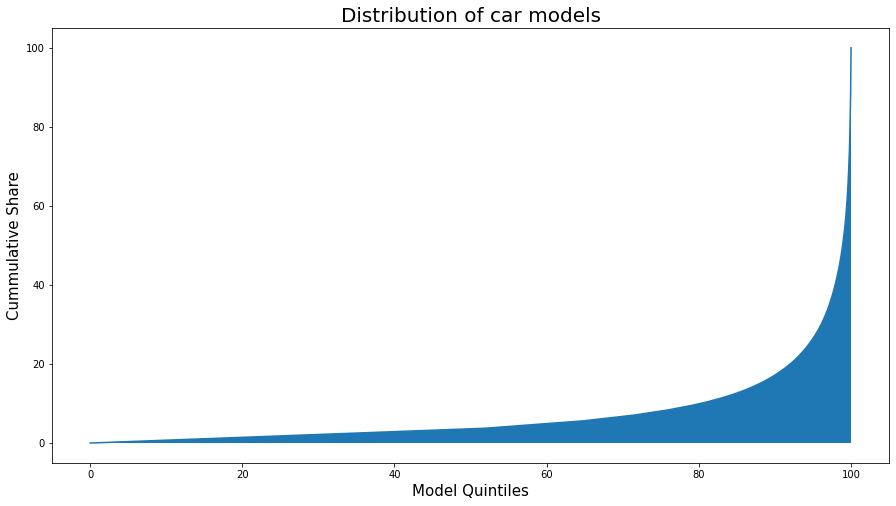

In [60]:
models_plot(models_dist(df1))

In [61]:
models[models["count"] ==1].sort_values("share of total (cum)", ascending=False)

model  count  \
8573                                      c30 fire truck      1   
6608                                                 a 4      1   
6637                                a3 3.2 quattro sline      1   
6523                                   WVWWF7AU5HW191345      1   
8590                               c300 c-300 luxury awd      1   
...                                                  ...    ...   
14666     flex sel 118k awd new tires 3rd row 118k 23mpg      1   
14664                                   flex secrossover      1   
14660                                          flex ltd.      1   
14659                            flex limited w/ecoboost      1   
0      $362.47, $1000 down, oac, 2.9%apr $362.47,luxu...      1   

       quintile (cum)  share of total (cum)  
8573        51.614208              3.698405  
6608        51.610531              3.698141  
6637        51.606854              3.697878  
6523        51.603177              3.697614  
8590        51.599500              3.697351  
...               ...                   ...  
14666        0.018385              0.001317  
14664        0.014708              0.001054  
14660        0.011031              0.000790  
14659        0.007354              0.000527  
0            0.003677              0.000263  

[14037 rows x 4 columns]

**More than 50% of the total car models have only one entry and account for only 3.7% of the total entries**

In [62]:
models[models["count"] <10].sort_values("share of total (cum)", ascending=False)

model  count  \
18393                                      mirage le cvt      9   
20244                               q5 2.0t premium plus      9   
16059                                     gx 470 4dr suv      9   
8636                                       c5500 topkick      9   
11798                           econoline e150 cargo van      9   
...                                                  ...    ...   
14666     flex sel 118k awd new tires 3rd row 118k 23mpg      1   
14664                                   flex secrossover      1   
14660                                          flex ltd.      1   
14659                            flex limited w/ecoboost      1   
0      $362.47, $1000 down, oac, 2.9%apr $362.47,luxu...      1   

       quintile (cum)  share of total (cum)  
18393       85.019856             12.651301  
20244       85.016179             12.648929  
16059       85.012502             12.646558  
8636        85.008825             12.644187  
11798       85.005148             12.641816  
...               ...                   ...  
14666        0.018385              0.001317  
14664        0.014708              0.001054  
14660        0.011031              0.000790  
14659        0.007354              0.000527  
0            0.003677              0.000263  

[23122 rows x 4 columns]

In [63]:
# Since I will be splitting the data using a 80/20 split, the train dataset should at least have one entry, 
# hence the car model should have at least 5 entries. However in order to be sure, I will drop all models with entries less 
# than 10
drop_models = models[models["count"] <10]["model"]
df1 = df1[~df1["model"].isin(drop_models)]
df1.shape

(331525, 16)

### Handling missing values

In [64]:
missing_values(df1)

cylinders       41.842998
condition       38.586834
drive           30.624236
type            21.025262
manufacturer     1.903929
title_status     1.282860
lat              0.957997
long             0.957997
transmission     0.421084
fuel             0.246739
region           0.000000
price            0.000000
year             0.000000
model            0.000000
odometer         0.000000
state            0.000000
dtype: float64

In [65]:
# Getting the values for the same model from other rows.

cols = ["cylinders", "drive", "type", "manufacturer", "fuel", "transmission"]


for col in cols:
    df11 = df1[df1[col].notna()].copy(deep = True)
    dict_ = {}
    for k, v in df11[['model', col]].values:
        dict_[k] = v
        
    df1.loc[:, col] = df1.apply( lambda x: x[col] if pd.notna( x[col] )
                                        else dict_[x['model']] if x['model'] in dict_.keys() 
                                        else x[col], axis=1)

del df11, dict_

In [66]:
missing_values(df1)

condition       38.586834
cylinders        7.376518
drive            3.771963
manufacturer     1.750396
title_status     1.282860
lat              0.957997
long             0.957997
type             0.711259
fuel             0.065153
region           0.000000
price            0.000000
year             0.000000
model            0.000000
odometer         0.000000
transmission     0.000000
state            0.000000
dtype: float64

In [67]:
df1.dropna(subset = ["fuel", "type", "title_status", "lat", "long", "manufacturer", "drive", "cylinders"], inplace=True)

In [68]:
df1.drop_duplicates(keep = "first", inplace = True)

In [69]:
missing_values(df1)

condition       38.217822
region           0.000000
price            0.000000
year             0.000000
manufacturer     0.000000
model            0.000000
cylinders        0.000000
fuel             0.000000
odometer         0.000000
title_status     0.000000
transmission     0.000000
drive            0.000000
type             0.000000
state            0.000000
lat              0.000000
long             0.000000
dtype: float64

In [70]:
models_keep = df1[df1["condition"].notna()]["model"].unique()
df1[~df1["model"].isin(models_keep)].shape[0]/df1.shape[0]*100

0.6942574257425742

In [71]:
df1 = df1[df1["model"].isin(models_keep)].sort_values(["model", "odometer", "price", "year"])

In [72]:
df1["condition"].unique()

['excellent', 'like new', NaN, 'good', 'fair', 'new', 'salvage']
Categories (6, object): ['excellent', 'fair', 'good', 'like new', 'new', 'salvage']

In [73]:
df1["condition"].replace(['new', 'like new', 'excellent', 'good', 'fair','salvage'], [1, 2, 3, 4, 5, 6], inplace=True)
df1["condition"] = pd.to_numeric(df1["condition"])

In [74]:
df1.groupby("condition")["region"].count()

condition
1.0      660
2.0    13780
3.0    60928
4.0    75535
5.0     4681
6.0      416
Name: region, dtype: int64

In [75]:
imputer = KNNImputer(n_neighbors=10)
imputed_cond = []

for model in df1["model"].unique().tolist():
    col = df1[df1["model"] ==model]
    imputed_cond.append(imputer.fit_transform(col[["condition"]]))
    
df1["condition"] = np.concatenate(imputed_cond, axis = 0)
df1["condition"] = round(df1["condition"], 0)  

In [76]:
df1.groupby("condition")["region"].count()

condition
1.0       674
2.0     14400
3.0    146016
4.0     84435
5.0      4709
6.0       513
Name: region, dtype: int64

In [77]:
df1.duplicated().sum()

20

In [137]:
df_clean = df1.drop_duplicates(keep="first")

In [138]:
missing_values(df_clean)

region          0.0
price           0.0
year            0.0
manufacturer    0.0
model           0.0
condition       0.0
cylinders       0.0
fuel            0.0
odometer        0.0
title_status    0.0
transmission    0.0
drive           0.0
type            0.0
state           0.0
lat             0.0
long            0.0
dtype: float64

In [139]:
df1.shape

(250747, 16)

## Further Cleaning and Visualization

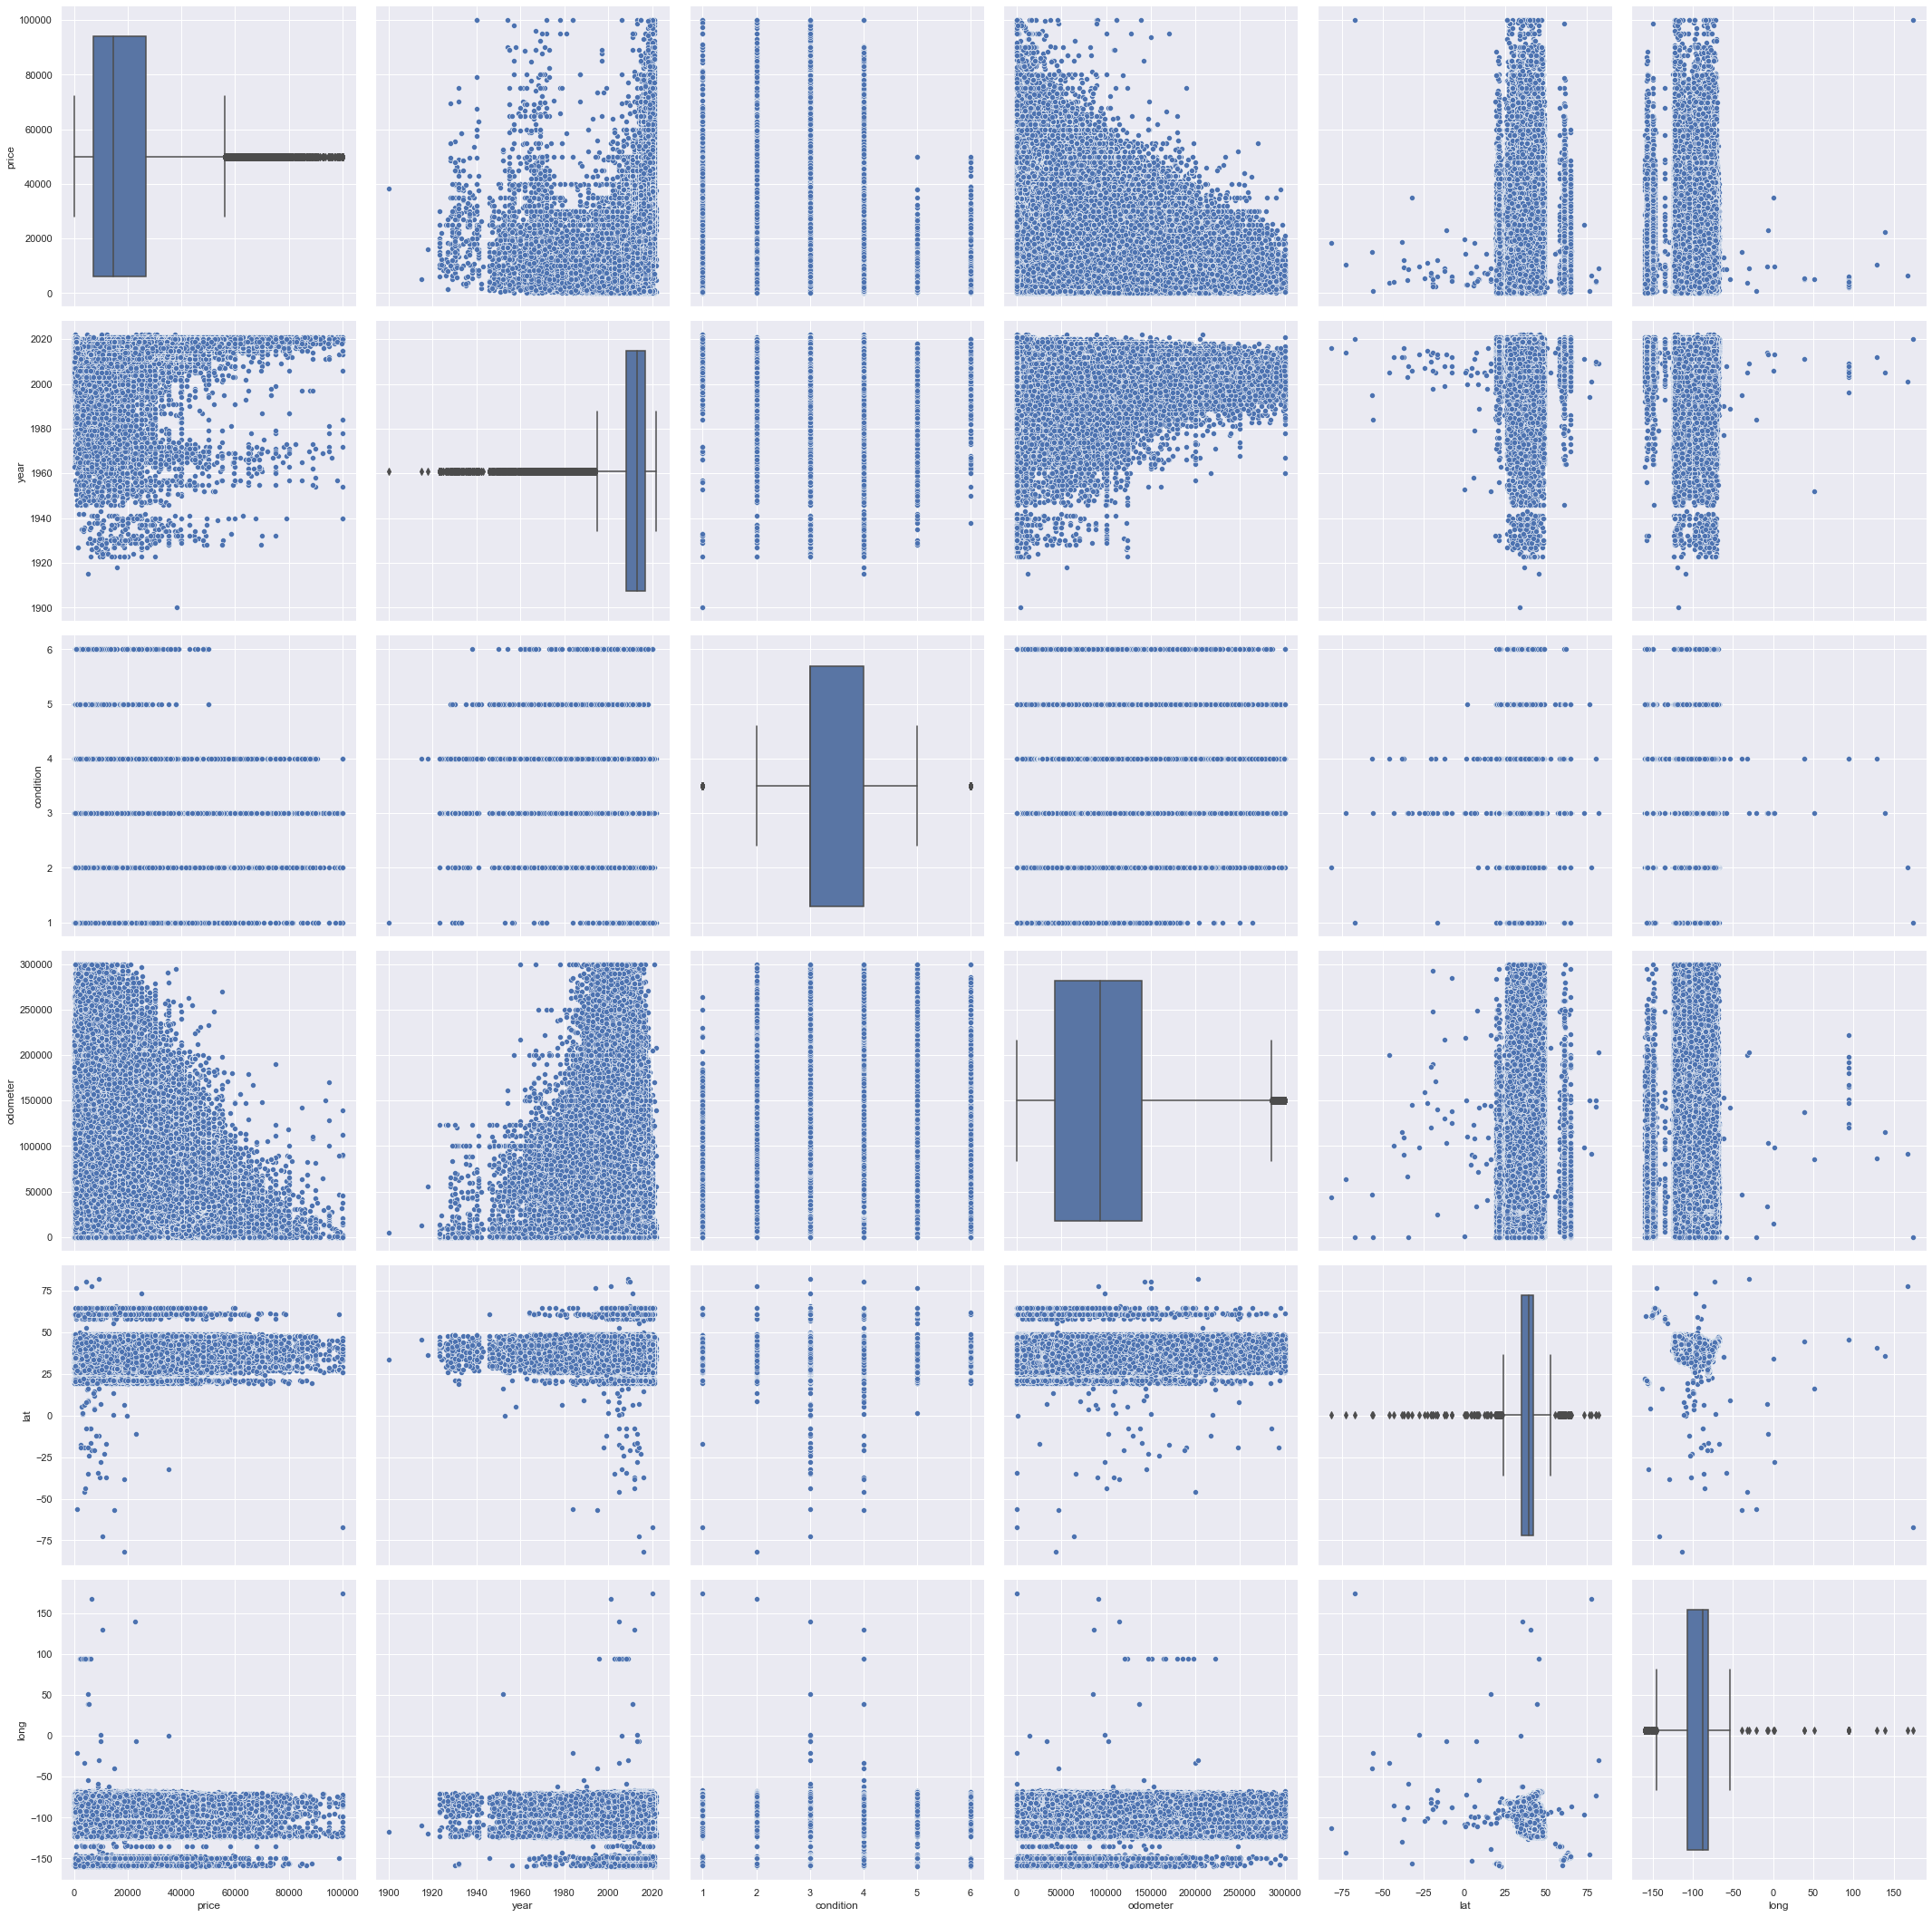

In [140]:
g = sns.PairGrid(df_clean, height=5)
g.map_diag(sns.boxplot)
g.map_offdiag(sns.scatterplot)
plt.show()

In [141]:
drop_years = df_clean[(df_clean["year"] <1996) | (df_clean["price"] > 55000) | (df_clean["odometer"] >280000)].index
df_clean = df_clean.drop(drop_years, axis=0)

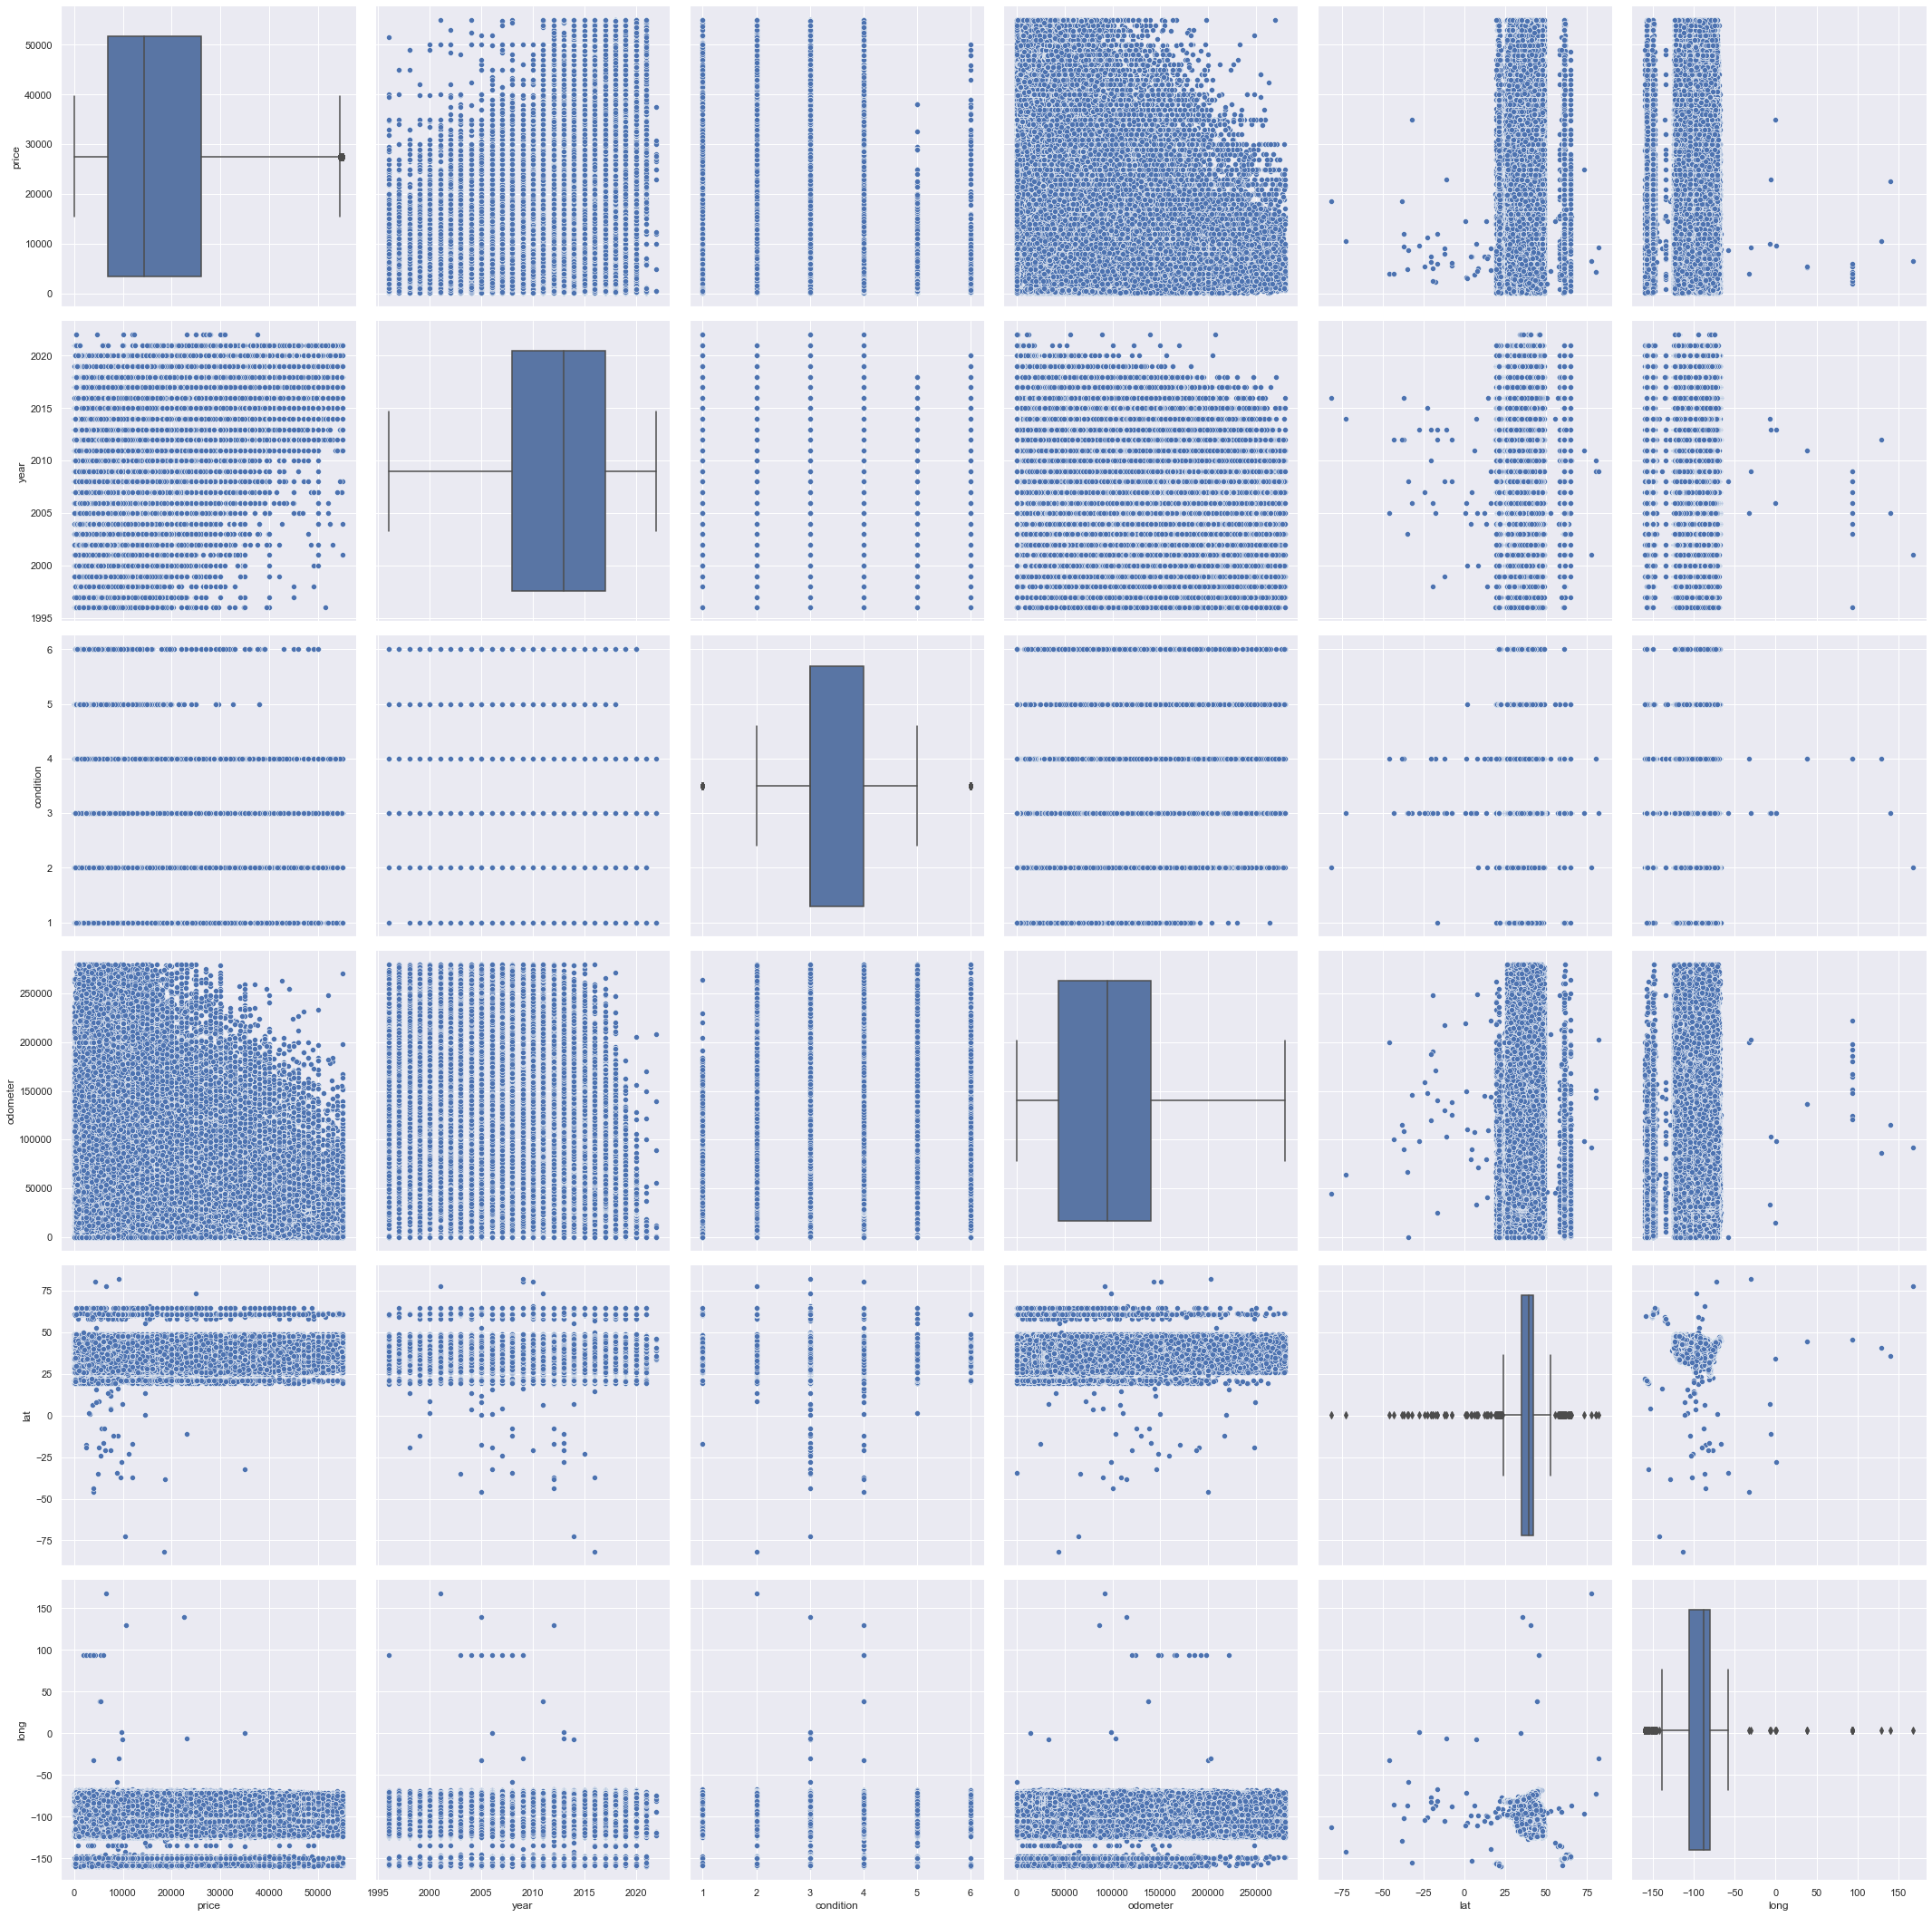

In [142]:
g = sns.PairGrid(df_clean, height=5)
g.map_diag(sns.boxplot)
g.map_offdiag(sns.scatterplot)
plt.show()

In [143]:
sns.set(rc={'figure.figsize':(13,8)})

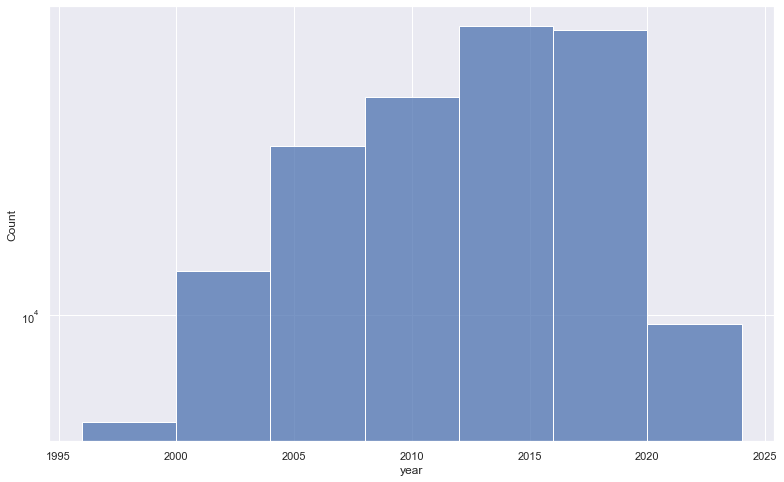

In [144]:
ax = sns.histplot(data=df_clean, x="year", binwidth=4)
ax.set_yscale('log')
plt.show()

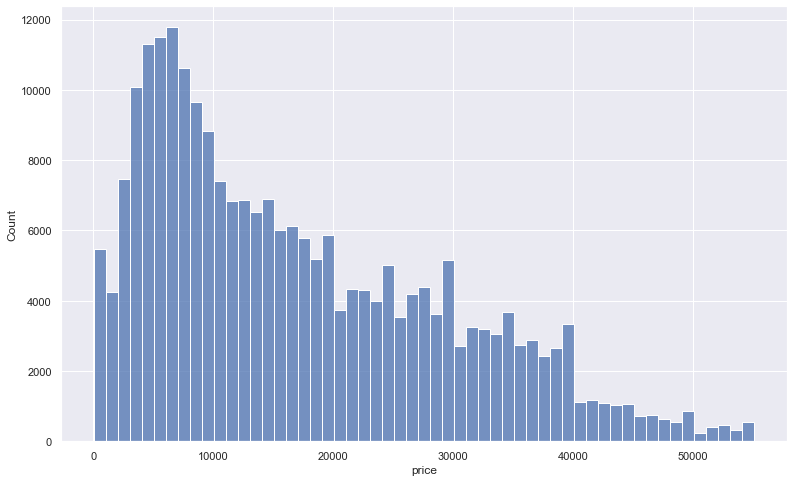

In [145]:
sns.histplot( x=df_clean["price"], binwidth=1000)
plt.show()

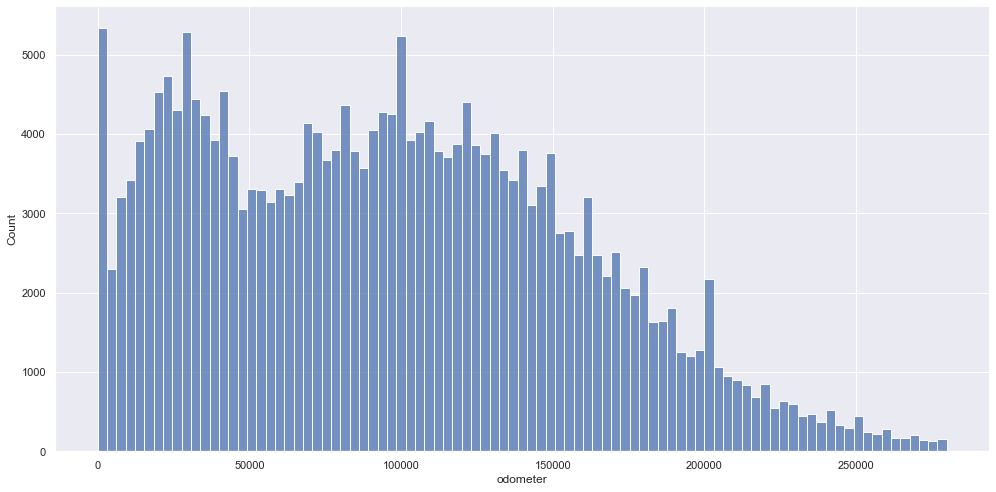

In [146]:
ax = sns.displot(data=df_clean, x="odometer", height = 7, aspect = 2)
plt.show()

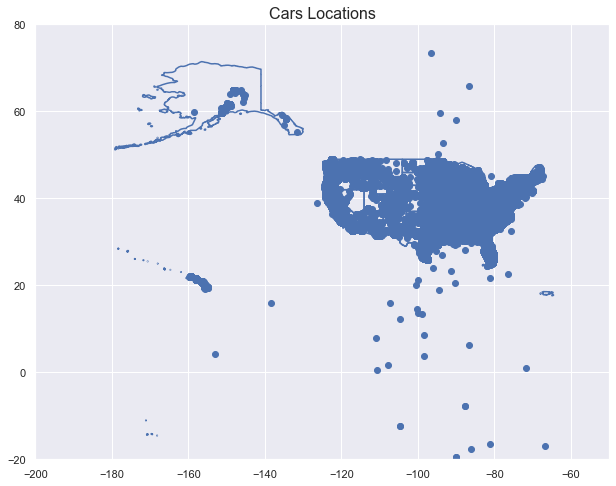

In [147]:
states = geopandas.read_file('./data/tl_2021_us_state.shx')

states.boundary.plot(figsize=(15,8))
plt.title('Cars Locations', fontsize=16)
plt.xlim([-200, -50])
plt.ylim([-20,80])
plt.scatter(x = df_clean['long'], y = df_clean['lat'], marker = "o")
plt.show()

In [148]:
df_clean[["lat", "long"]].describe([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

lat           long
count  237733.000000  237733.000000
mean       38.475805     -93.475265
std         5.716719      17.660319
min       -81.838232    -159.707445
1%         25.909860    -149.865983
5%         28.138400    -122.371376
25%        34.830000    -105.264650
50%        39.337094     -87.633814
75%        42.340777     -80.640000
95%        46.553190     -72.920000
99%        48.754800     -71.064426
max        82.252826     167.629911

In [149]:
to_drop = df_clean[(df_clean["lat"] <25.909800) | (df_clean["lat"] > 48.754800) |
          (df_clean["long"] <-149.865983) | (df_clean["long"] > -71.064426)]

df_clean = df_clean.drop(to_drop.index, axis = 0)

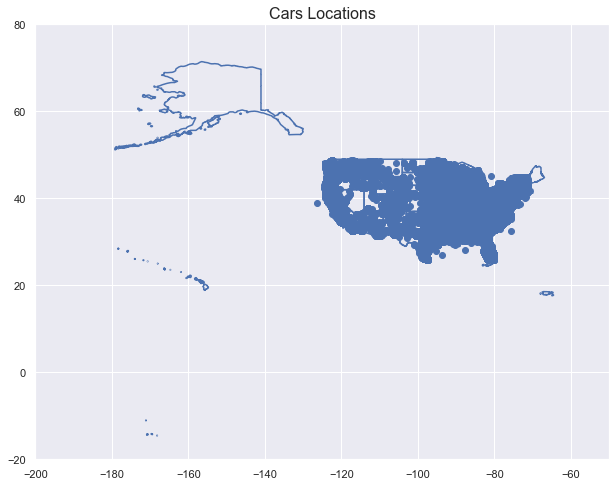

In [150]:
states.boundary.plot(figsize=(15,8))
plt.title('Cars Locations', fontsize=16)

plt.xlim([-200, -50])
plt.ylim([-20,80])

# plt.xlim([-130, -60])
# plt.ylim([20, 60])
plt.scatter(x = df_clean['long'], y = df_clean['lat'], marker = "o")
plt.show()

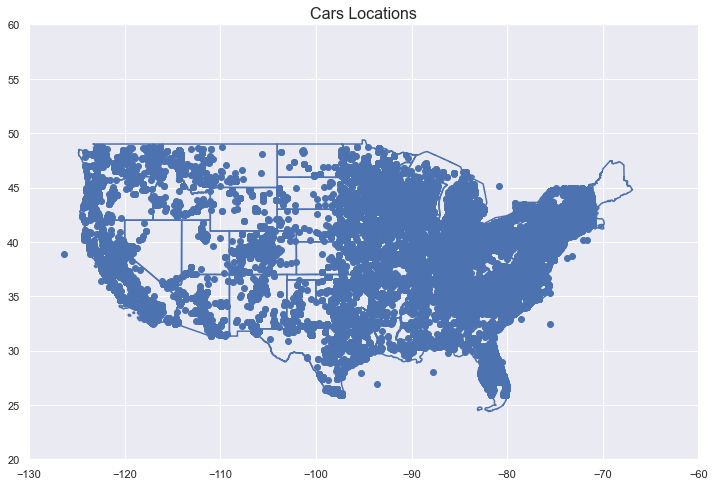

In [151]:
states.boundary.plot(figsize=(15,8))
plt.title('Cars Locations', fontsize=16)

# plt.xlim([-200, -50])
# plt.ylim([-20,80])

plt.xlim([-130, -60])
plt.ylim([20, 60])
plt.scatter(x = df_clean['long'], y = df_clean['lat'], marker = "o")
plt.show()

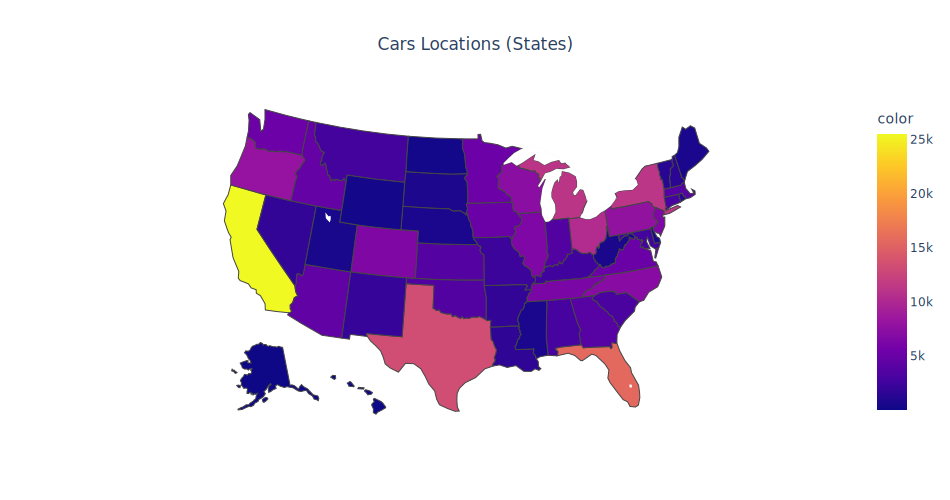

In [152]:
df_state = df_clean.groupby(by = ['state'])['region'].count().reset_index().sort_values(by = "region", ascending=False)
df_state.rename(columns={"region":"count"}, inplace=True)
df_state["state"] = df_state["state"].str.upper()

fig = px.choropleth(locations=df_state["state"], locationmode="USA-states", color=df_state["count"],
                    scope="usa", title="Cars Locations (States)")
fig.update_layout(title_x=0.5, width = 950)
fig.show("svg")

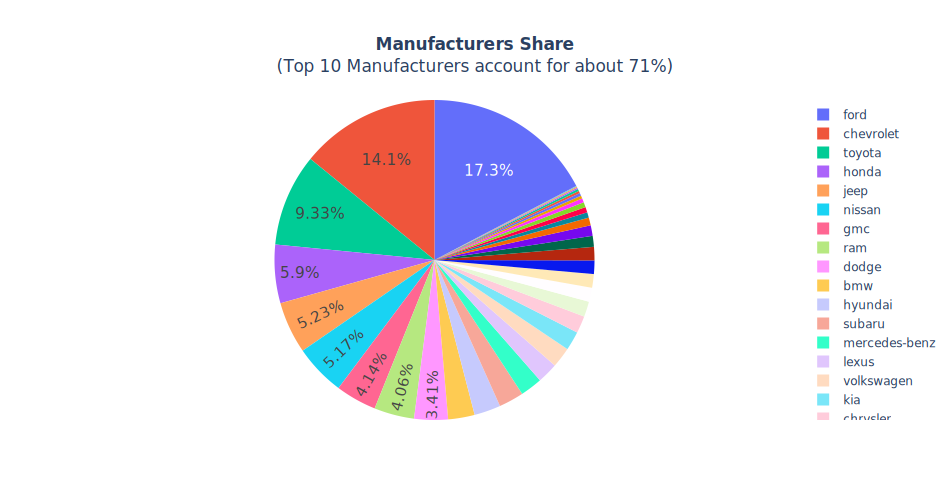

In [153]:
manufacturers = df_clean.groupby('manufacturer')['region'].count().reset_index().sort_values(by = "region", ascending=False)
manufacturers.rename(columns={"region":"count"}, inplace=True)
sum_man = int(round(manufacturers["count"].head(10).sum()/manufacturers["count"].sum()*100, 0))

fig = px.pie(manufacturers, values='count',  
             title= "<b>Manufacturers Share</b><br>(Top 10 Manufacturers account for about {}%)" .format(sum_man),
             names="manufacturer")
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize = 15.3, uniformtext_mode='hide', title_x=0.5, width = 950)
fig.show("svg")


In [154]:
u1p_sum = manufacturers[manufacturers["count"] < sum(manufacturers["count"])/100]["count"].sum()
u1p_cnt = manufacturers[manufacturers["count"] < sum(manufacturers["count"])/100]["manufacturer"].nunique()
u1p_acc = round(10980/sum(manufacturers["count"]),4)
print("Summary of cars manufacturers with listings shares less than 1%\n\n" +
      tabulate([(u1p_cnt, u1p_sum, u1p_acc*100)], headers= ["Sum", "Count", "Accumulated Share"]))

Summary of cars manufacturers with listings shares less than 1%

  Sum    Count    Accumulated Share
-----  -------  -------------------
   14     9643                 4.76


In [155]:
# Deleting manufacturers with cars share of less than 1%
to_drop = manufacturers[manufacturers["count"] < sum(manufacturers["count"])/100]["manufacturer"].unique()
df_clean = df_clean[~df_clean["manufacturer"].isin(to_drop)]

# Number of Manfucaturers left 
df_clean["manufacturer"].nunique()

24

In [156]:
def plot_types(df):
    col_names = ["condition", "cylinders", "drive", "fuel", "title_status", "transmission", "type"]
    names = ["condition", "title_status", "cylinders", "transmission",  "drive", "type", "fuel"] 

    fig = make_subplots(
        rows = 4, cols = 2,
        subplot_titles=(names),
         specs=[[{"type": "domain"}, {"type": "domain"}],
                [{"type": "domain"}, {"type": "domain"}],
                [{"type": "domain"}, {"type": "domain"}],
                [{"type": "domain"}, {"type": "domain"}]])

    for i in range (len(col_names)):
        df_count = df.groupby(col_names[i])[['region']].count().reset_index().rename(columns={"region":"count"})
        df_count = df_count.sort_values(by = 'count')
        labels = df_count.iloc[:, 0]
        values = df_count.iloc[:, 1]

        if i < 4:
            fig.add_trace(go.Pie(values = values, labels = labels), row=i+1, col=1)
        elif i >= 4:
            fig.add_trace(go.Pie(values = values, labels = labels), row=i-3, col=2)



    fig.update_layout(height=1500, width=1000,
                      title_text="Shares in cars")

    fig.update_layout(title_x=0.5)
    fig.update_traces(textposition='inside')
    fig.show("svg")

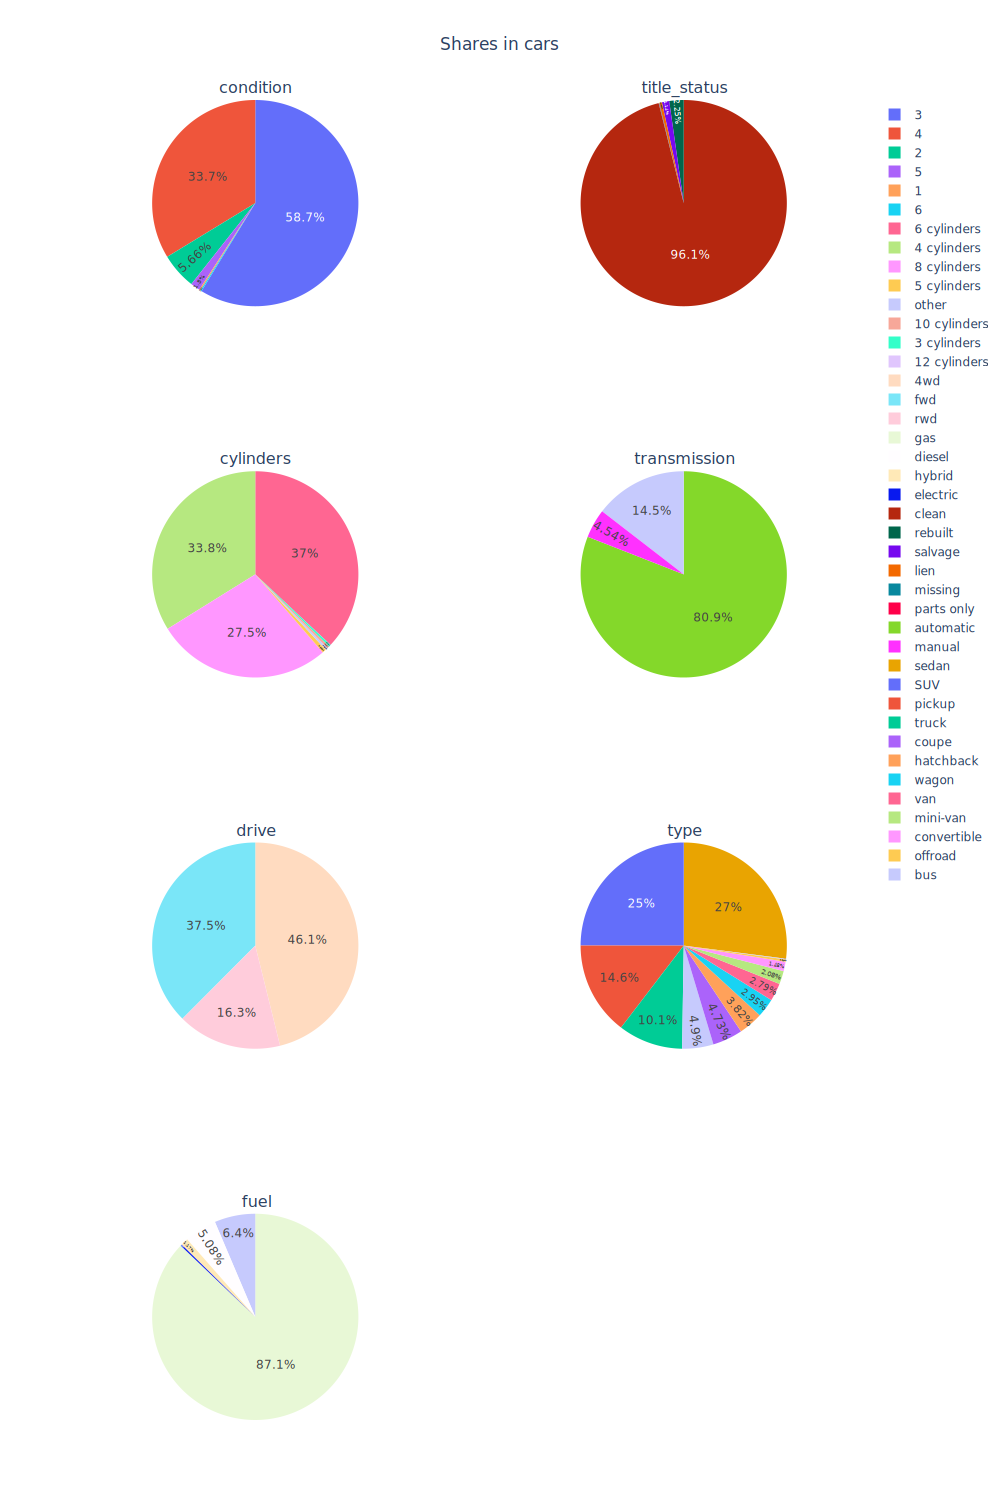

In [159]:
plot_types(df_clean)

In [160]:
df_clean.groupby("condition").agg({"price":"mean", "odometer":"mean"})

price       odometer
condition                             
1.0        20905.254737   60310.453125
2.0        17719.405103   83299.695312
3.0        16192.629005  103245.250000
4.0        20331.513888   86836.453125
5.0         3669.765078  171555.796875
6.0         8585.900966  135242.812500

In [161]:
# Deleting all features with shares less than 1%
df_clean = df_clean[~df_clean["condition"].isin([1, 6])]
df_clean = df_clean[df_clean["cylinders"].isin(["6 cylinders", "4 cylinders", "8 cylinders"])]
df_clean = df_clean[~df_clean["type"].isin(["offroad", "bus"])]
df_clean = df_clean[~df_clean["title_status"].isin(["lien", "missing", "parts only"])]

# Combine electric and hybrid 
df_clean.replace(["electric", "hybrid"], ["electric_or_hybrid", "electric_or_hybrid"], inplace = True)

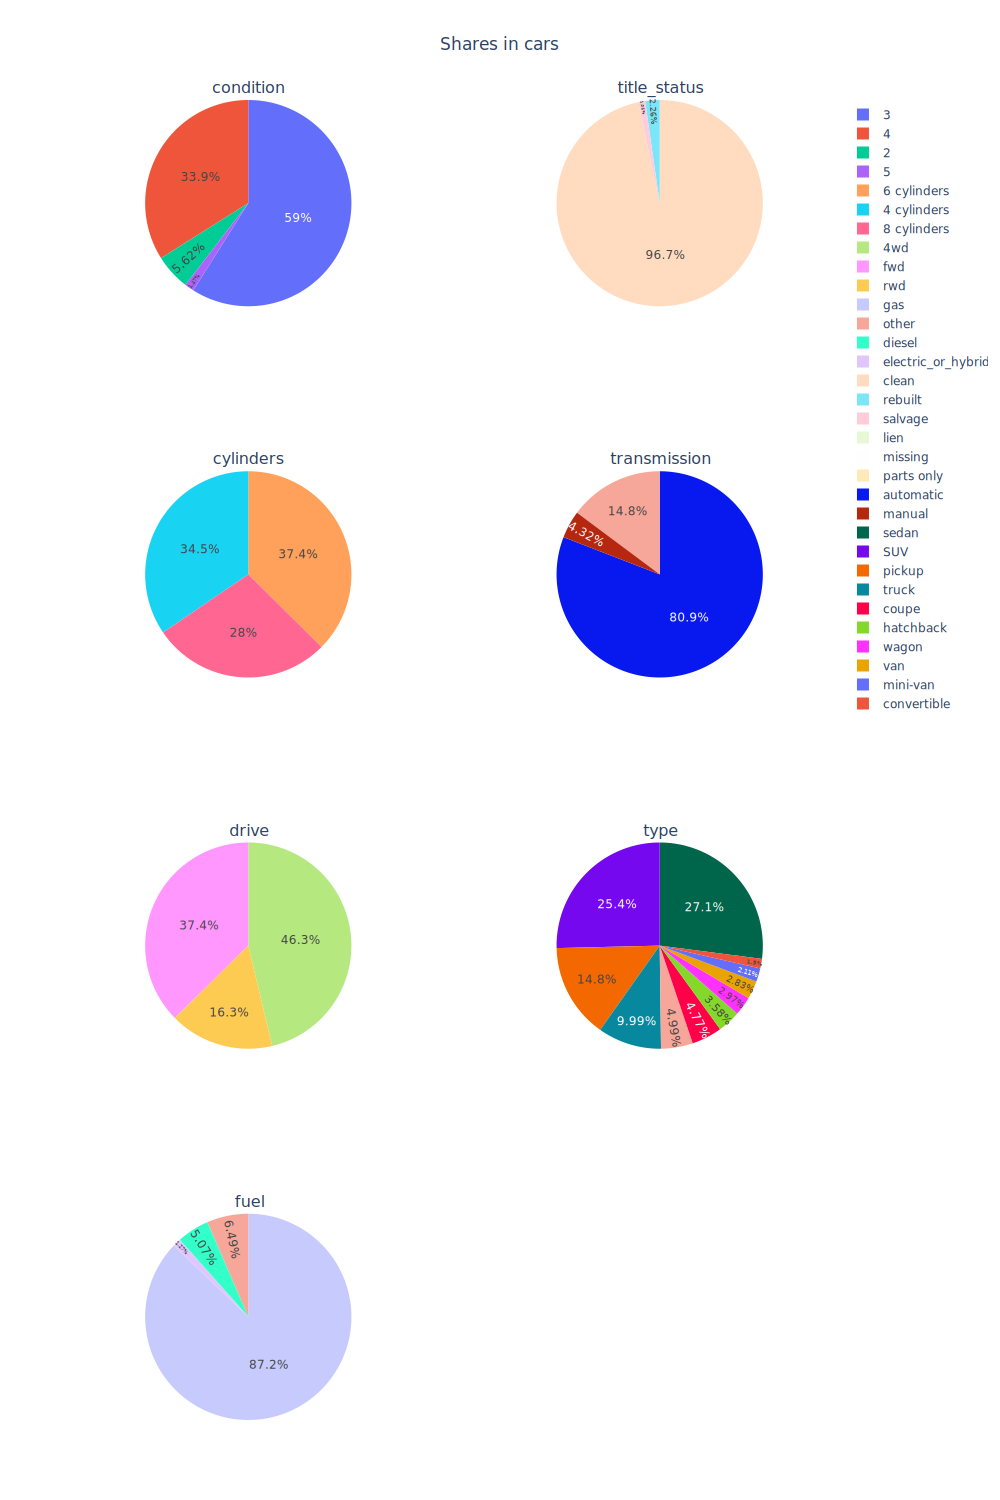

In [162]:
plot_types(df_clean)

In [163]:
models_dist(df_clean).sort_values("count", ascending =False).head(10).sort_values("share of total (cum)").head(5)

model  count  quintile (cum)  share of total (cum)
989    explorer   1734       99.665428             89.235187
320      altima   1831       99.702602             90.088708
2144  silverado   1891       99.739777             90.970199
950      escape   1937       99.776952             91.873132
584       civic   2036       99.814126             92.822215

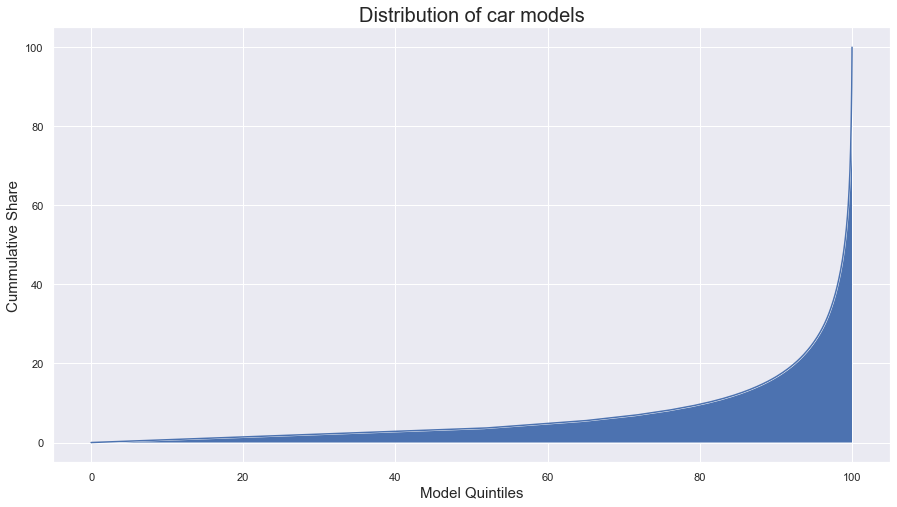

In [164]:
# Intitial Dataframe 
models_plot(models_dist(df_initial))

In [165]:
print("length of initial dataset:", len(df_initial))
print("Number of models in the initial dataset:", df_initial["model"].nunique()) 

length of initial dataset: 426880
Number of models in the initial dataset: 29667


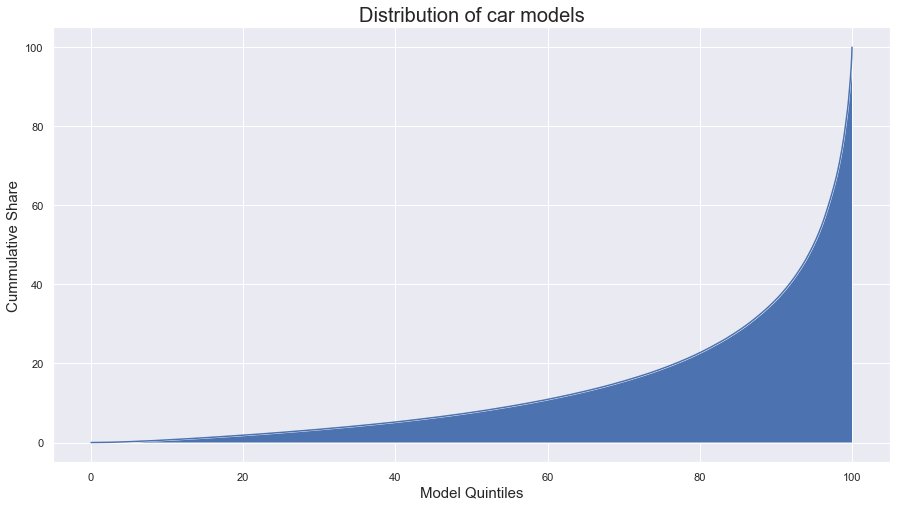

In [166]:
# Cleaned Dataframe
models_plot(models_dist(df_clean))

In [167]:
print("length of clean dataset:", len(df_clean))
print("Number of models in the clean dataset:", df_clean["model"].nunique()) 

length of clean dataset: 214523
Number of models in the clean dataset: 2690


## Preparing Data for modeling

In [79]:
df_models = df_clean.copy(deep= True)
df_models.head(1)

region  price    year manufacturer model  condition  \
135977  spokane / coeur d'alene  18995  2013.0          bmw  128i        3.0   

          cylinders fuel  odometer title_status transmission drive   type  \
135977  6 cylinders  gas   40443.0        clean    automatic   fwd  coupe   

       state        lat        long  
135977    id  47.699801 -116.791144

In [80]:
drop_col = [0, 1, 4, 13]

X = np.delete(df_models.values, drop_col, 1) 
y = df_models.iloc[:, 1].values

df_dtype = pd.DataFrame(df_models.drop(columns=df_models.iloc[:, (drop_col)].columns).dtypes)\
            .reset_index().rename(columns={0:"dtype"})

# Getting categorical and numeric columns numbers

cat_col = df_dtype[((df_dtype.dtype !="float32") & (df_dtype.dtype !="float64")) ].index.values
num_col = df_dtype[((df_dtype.dtype =="float32") | (df_dtype.dtype =="float64")) ].index.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


labels = pd.get_dummies(df_models.drop(df_models.columns[drop_col], axis =1)).columns


ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), cat_col),
                                      ('scaler', StandardScaler(), num_col)],
                       sparse_threshold=0,   remainder = 'passthrough')

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

## Different Predicting Methods

In [84]:
def model_eval(y_actual, y_pred, name):
    
    index = []
    scores = {"MSE": [], "RMSE": [], 
          "MASE": [], "RE" :[], "R2_squared": []} 
    
    index += [name]
    
    scores["MSE"].append(round(metrics.mean_squared_error(y_actual, y_pred),2))
    scores["RMSE"].append(round(math.sqrt(metrics.mean_squared_error(y_actual, y_pred)),2))
    scores["MASE"].append(round(metrics.mean_absolute_error(y_actual, y_pred),2))
    scores["RE"].append(round(metrics.mean_absolute_error(y_actual, y_pred)*len(y_actual)/sum(abs(y_actual)), 4))
    scores["R2_squared"].append(round(metrics.explained_variance_score(y_actual, y_pred),2))

    df_scores = pd.DataFrame(scores, index=index)
                        
    return df_scores

In [127]:
def cv_result(model, index_name):
    
    scoring_metrics = {"MSE":"neg_mean_squared_error", "RMSE":"neg_root_mean_squared_error",
                       "MASE": "neg_mean_absolute_error", "r2_score" : "r2"}
    result = cross_validate(model, X_train, y_train, scoring=scoring_metrics, cv=5, n_jobs = -1)
    
    index = []
    scores = {"MSE": [], "RMSE": [], "MASE": [], "RE" :[], "R2_squared": []} 
    
    index += [index_name]
    
    scores["MSE"].append(round(result["test_MSE"].mean()*-1 ,2))
    scores["RMSE"].append(round(result["test_RMSE"].mean()*-1 ,2))
    scores["MASE"].append(round(result["test_MASE"].mean()*-1 ,2))
    scores["RE"].append(round(result["test_MASE"].mean()*-1*len(y_train)/sum(abs(y_train)), 4))
    scores["R2_squared"].append(round(result["test_r2_score"].mean() ,2))

    df_scores = pd.DataFrame(scores, index=index)
    return df_scores

### Baseline Average Price

In [126]:
baseline = pd.DataFrame(y_test, columns={"actual"})
baseline["prediction"] = mean(y_train)


baseline = model_eval(baseline["actual"], baseline["prediction"], "Avg Price Model")
baseline

MSE      RMSE      MASE      RE  R2_squared
Avg Price Model  1.519683e+08  12327.54  10305.61  0.5862         0.0

### Simple Linear Regression

In [129]:
LR = LinearRegression()

cv_LR = cv_result(LR, "Linear Regression")
cv_LR

MSE     RMSE    MASE      RE  R2_squared
Linear Regression  39584034.81  6291.45  4387.9  0.2502        0.74

### Decision Tree Regressor

In [132]:
DTR = DecisionTreeRegressor()

cv_DTR = cv_result(DTR, "Decision Tree Regressor")
cv_DTR

MSE     RMSE     MASE      RE  R2_squared
Decision Tree Regressor  28363727.79  5325.43  2561.69  0.1461        0.81

In [135]:
DTR = DecisionTreeRegressor(max_depth=30, min_samples_leaf=2, random_state=0)

cv_DTRt = cv_result(DTR, "Decision Tree Regressor tuned")
cv_DTRt

MSE     RMSE     MASE      RE  \
Decision Tree Regressor tuned  26480709.65  5145.55  2690.96  0.1535   

                               R2_squared  
Decision Tree Regressor tuned        0.83

### Random Forest Regressor

In [136]:
RFR = RandomForestRegressor(random_state=0, n_jobs= -1)

cv_RFR = cv_result(RFR, "Random Forest Regressor")
cv_RFR

MSE     RMSE     MASE      RE  R2_squared
Random Forest Regressor  15489383.01  3935.28  2046.72  0.1167         0.9

In [137]:
RFRt = RandomForestRegressor(n_estimators=200, max_features=0.25, random_state=0, n_jobs= -1)

cv_RFRt = cv_result(RFRt, "Random Forest Regressor tuned")
cv_RFRt

MSE     RMSE     MASE      RE  \
Random Forest Regressor tuned  14277619.37  3778.13  1976.86  0.1127   

                               R2_squared  
Random Forest Regressor tuned        0.91

### XGBoost Regressor

In [138]:
xgb = XGBRegressor(random_state = 0, n_jobs = -1)

cv_XGBR = cv_result(xgb, "XGBoost Regressor")
cv_XGBR

MSE     RMSE     MASE     RE  R2_squared
XGBoost Regressor  16991859.54  4121.78  2682.35  0.153        0.89

In [146]:
xgbt = XGBRegressor(n_estimators = 1000, learning_rate= 0.20, max_depth = 9, max_bin = 5000, gamma = 10, reg_lambda = 5,
                   tree_method = "gpu_hist", use_rmm = True,  random_state = 0)

cv_XGBRt = cv_result(xgbt, "XGBoost Regressor tuned")
cv_XGBRt

MSE     RMSE     MASE     RE  R2_squared
XGBoost Regressor tuned  10131923.79  3182.58  1858.32  0.106        0.93

### Summary

In [140]:
pd.concat([baseline, cv_LR, cv_DTR, cv_DTRt, cv_RFR, cv_RFRt, cv_XGBR, cv_XGBRt])

MSE      RMSE      MASE      RE  \
Avg Price Model                1.519683e+08  12327.54  10305.61  0.5862   
Linear Regression              3.958403e+07   6291.45   4387.90  0.2502   
Decision Tree Regressor        2.836373e+07   5325.43   2561.69  0.1461   
Decision Tree Regressor tuned  2.648071e+07   5145.55   2690.96  0.1535   
Random Forest Regressor        1.548938e+07   3935.28   2046.72  0.1167   
Random Forest Regressor tuned  1.427762e+07   3778.13   1976.86  0.1127   
XGBoost Regressor              1.699186e+07   4121.78   2682.35  0.1530   
XGBoost Regressor tuned        1.030009e+07   3209.00   1848.12  0.1054   

                               R2_squared  
Avg Price Model                      0.00  
Linear Regression                    0.74  
Decision Tree Regressor              0.81  
Decision Tree Regressor tuned        0.83  
Random Forest Regressor              0.90  
Random Forest Regressor tuned        0.91  
XGBoost Regressor                    0.89  
XGBoost Regressor tuned              0.93

### Best Algorithm in action

In [140]:
xgb = XGBRegressor(n_estimators = 1000, learning_rate= 0.30, max_depth = 9, max_bin = 5000, gamma = 10, reg_lambda = 5,
                   tree_method = "gpu_hist", use_rmm = True,  random_state = 0)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

xgb_model_tuned = model_eval(y_test, y_pred_xgb, "XGBRegressor tuned")
xgb_model_tuned

MSE     RMSE    MASE      RE  R2_squared
XGBRegressor tuned  9774162.26  3126.37  1793.7  0.1022        0.94

In [142]:
xgb = XGBRegressor(n_estimators = 1000, learning_rate= 0.3, max_depth = 10, max_bin = 5000, gamma = 10, reg_lambda = 5,
                   tree_method = "gpu_hist", use_rmm = True,  random_state = 0)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

model_eval(y_test, y_pred_xgb, "XGBRegressor tuned")

MSE     RMSE     MASE      RE  R2_squared
XGBRegressor tuned  9925772.86  3150.52  1762.26  0.1004        0.93

In [145]:
xgb = XGBRegressor(n_estimators = 1000, learning_rate= 0.2, max_depth = 9, max_bin = 5000, gamma = 10, reg_lambda = 5,
                   tree_method = "gpu_hist", use_rmm = True,  random_state = 0)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

model_eval(y_test, y_pred_xgb, "XGBRegressor tuned")

MSE     RMSE    MASE      RE  R2_squared
XGBRegressor tuned  9087016.96  3014.47  1777.7  0.1011        0.94

## Outtakes tuning

Best: -3668.400757 using {'learning_rate': 0.2, 'n_estimators': 1000}
-3834.060197 (37.509206) with: {'learning_rate': 0.2, 'n_estimators': 500}
-3710.698193 (36.273386) with: {'learning_rate': 0.2, 'n_estimators': 800}
-3668.400757 (38.409932) with: {'learning_rate': 0.2, 'n_estimators': 1000}
-3773.730114 (42.437313) with: {'learning_rate': 0.3, 'n_estimators': 500}
-3694.702483 (42.635185) with: {'learning_rate': 0.3, 'n_estimators': 800}
-3668.894906 (42.259654) with: {'learning_rate': 0.3, 'n_estimators': 1000}
-3792.561727 (38.150976) with: {'learning_rate': 0.4, 'n_estimators': 500}
-3731.952560 (41.804417) with: {'learning_rate': 0.4, 'n_estimators': 800}
-3717.108429 (38.429525) with: {'learning_rate': 0.4, 'n_estimators': 1000}


Text(0, 0.5, 'Log Loss')

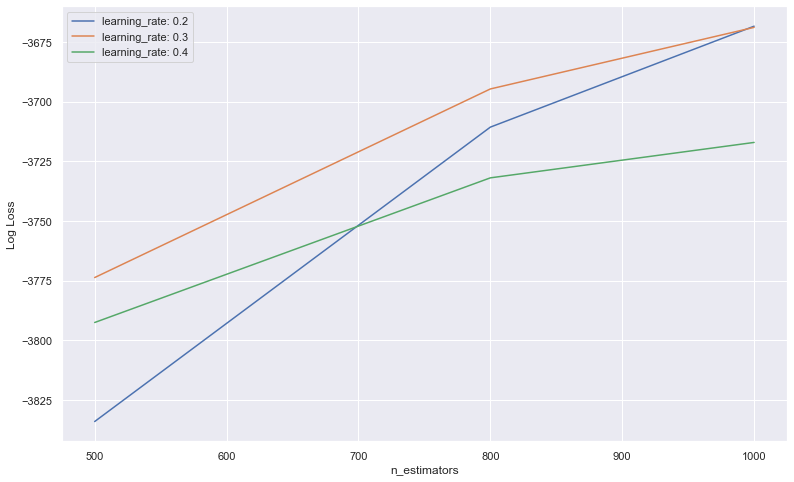

In [142]:
# Tuning  n_estimators and learning_rate with gpu_hist tree_method

xgb = XGBRegressor(tree_method = "gpu_hist", random_state = 0) 

n_estimators = [500, 800, 1000]
learning_rate = [0.2, 0.3, 0.4]

param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
kfold = KFold(n_splits=3, shuffle=True)

grid_search = GridSearchCV(xgb, param_grid, scoring="neg_root_mean_squared_error", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)


# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# plot results
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')

In [144]:
# Tuning max_depth
xgb = XGBRegressor(tree_method = "gpu_hist", n_estimators = 1000, learning_rate = 0.2, random_state = 0) 

param_grid = dict(max_depth=[6, 7, 8, 9, 10])

kfold = KFold(n_splits=3, shuffle=True)

grid_search = GridSearchCV(xgb, param_grid, scoring="neg_root_mean_squared_error", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)


# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -3522.612803 using {'max_depth': 9}
-3674.747361 (3.814923) with: {'max_depth': 6}
-3576.331098 (10.546274) with: {'max_depth': 7}
-3535.173383 (20.067552) with: {'max_depth': 8}
-3522.612803 (8.838840) with: {'max_depth': 9}
-3528.316204 (10.125388) with: {'max_depth': 10}


In [134]:
model = XGBRegressor(tree_method = "gpu_hist", random_state = 0)

n_estimators = [700, 800, 1000]
learning_rate = [0.2, 0.3]
max_bin = [1000, 2000, 3000, 5000]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, max_bin = max_bin)
kfold = KFold(n_splits=3, shuffle=True)

grid_search = GridSearchCV(model, param_grid, scoring="neg_root_mean_squared_error", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)
                              
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: -3438.110455 using {'learning_rate': 0.3, 'max_bin': 5000, 'n_estimators': 1000}
-3644.373843 (26.930268) with: {'learning_rate': 0.2, 'max_bin': 1000, 'n_estimators': 700}
-3609.976496 (25.599598) with: {'learning_rate': 0.2, 'max_bin': 1000, 'n_estimators': 800}
-3563.172487 (21.956507) with: {'learning_rate': 0.2, 'max_bin': 1000, 'n_estimators': 1000}
-3602.665547 (25.978416) with: {'learning_rate': 0.2, 'max_bin': 2000, 'n_estimators': 700}
-3565.596024 (27.233012) with: {'learning_rate': 0.2, 'max_bin': 2000, 'n_estimators': 800}
-3515.439984 (30.397351) with: {'learning_rate': 0.2, 'max_bin': 2000, 'n_estimators': 1000}
-3572.078948 (20.175591) with: {'learning_rate': 0.2, 'max_bin': 3000, 'n_estimators': 700}
-3535.769836 (21.937530) with: {'learning_rate': 0.2, 'max_bin': 3000, 'n_estimators': 800}
-3482.505061 (26.782348) with: {'learning_rate': 0.2, 'max_bin': 3000, 'n_estimators': 1000}
-3561.200741 (19.761672) with: {'learning_rate': 0.2, 'max_bin': 5000, 'n_estimato

ValueError: cannot reshape array of size 24 into shape (2,3)